### 

In [51]:
# make env
# pip install requests
# %pip install pandas
# %pip install matplotlib 
# %pip install -U scikit-learn
# %pip install imbalanced-learn

In [52]:
# Imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display, HTML
import matplotlib.pyplot as plt

### Load Dataset

In [53]:
# Dataset Source: https://www.kaggle.com/datasets/andrewsundberg/college-basketball-dataset?select=cbb13.csv

dataframes = {}
directory = 'march_mad_data'

# Load general cbb.csv dataset into a dataframe
for filename in os.listdir(directory):
    if filename.endswith("cbb.csv"):
        path = os.path.join(directory, filename)
        dataframes[filename] = pd.read_csv(path)

In [54]:
df = dataframes["cbb.csv"]
print(df)

                TEAM  CONF   G   W  ADJOE  ADJDE  BARTHAG  EFG_O  EFG_D   TOR  \
0     North Carolina   ACC  40  33  123.3   94.9   0.9531   52.6   48.1  15.4   
1          Wisconsin   B10  40  36  129.1   93.6   0.9758   54.8   47.7  12.4   
2           Michigan   B10  40  33  114.4   90.4   0.9375   53.9   47.7  14.0   
3         Texas Tech   B12  38  31  115.2   85.2   0.9696   53.5   43.0  17.7   
4            Gonzaga   WCC  39  37  117.8   86.3   0.9728   56.6   41.1  16.2   
...              ...   ...  ..  ..    ...    ...      ...    ...    ...   ...   
3518          Toledo   MAC  34  27  119.9  109.6   0.7369   56.3   52.9  13.6   
3519         Liberty  ASun  33  27  111.4   97.3   0.8246   55.5   49.3  16.0   
3520     Utah Valley   WAC  34  28  107.1   94.6   0.8065   51.7   44.0  19.3   
3521             UAB  CUSA  38  29  112.4   97.0   0.8453   50.3   47.3  17.3   
3522     North Texas  CUSA  36  31  110.0   93.8   0.8622   51.2   44.5  19.8   

      ...  FTRD  2P_O  2P_D

### Data Cleaning

In [55]:
clean_df = df.replace("N/A", "NA")
print(df["SEED"].unique())
print(f"number of rows: {len(clean_df)}")
print(f"number of columns: {len(clean_df.columns)}")

[ 1.  3.  8.  4.  2.  7.  6.  9. 11. 10.  5. nan 16. 12. 13. 14. 15.]
number of rows: 3523
number of columns: 24


# Drop columns we don't want


### Exploratory Data Analysis (EDA)

In [56]:
placement_df = clean_df.dropna()
print(placement_df["POSTSEASON"].unique())
# Define a dictionary to map the postseason labels to numbers
postseason_mapping = {'Champions': 1, '2ND': 2, 'F4': 3, 'E8': 4, 'S16': 5, 'R32': 6, 'R64': 7, 'R68': 8}

# Use the map() function to convert the values in the "POSTSEASON" column
placement_df['POSTSEASON'] = placement_df['POSTSEASON'].map(postseason_mapping)

print(placement_df["POSTSEASON"].unique())
print(len(placement_df))

['2ND' 'Champions' 'E8' 'F4' 'R32' 'R64' 'R68' 'S16']
[2 1 4 3 6 7 8 5]
680


C:\Users\seand\AppData\Local\Temp\ipykernel_50224\1306498176.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placement_df['POSTSEASON'] = placement_df['POSTSEASON'].map(postseason_mapping)


In [57]:
placement_df = placement_df.drop(columns=['YEAR', 'TEAM'])
one_hot_encoded = pd.get_dummies(placement_df['CONF'])
placement_df = placement_df.drop(columns=['CONF'])
placement_df = pd.concat([placement_df, one_hot_encoded], axis=1)
placement_df['WINRATE'] = placement_df['W'] / placement_df['G']

In [58]:
# Compare conference and whether the team qualifies for March Madness (EDA) !!!!!!!!!!!!!!!!!!!!!

In [59]:
from imblearn.over_sampling import RandomOverSampler

# Create a list of target values for seeds 1 and 2
target_values = [1, 2]

# Filter the original dataset to include only seeds 1 and 2
filtered_df = placement_df[placement_df['SEED'].isin(target_values)]

# Create an oversampler object
oversampler = RandomOverSampler(sampling_strategy='auto')

# Oversample the dataset
X_oversampled, y_oversampled = oversampler.fit_resample(filtered_df.drop('SEED', axis=1), filtered_df['SEED'])

# Create a new DataFrame with the oversampled data
oversampled_df = pd.DataFrame(X_oversampled, columns=filtered_df.drop('SEED', axis=1).columns)
oversampled_df['SEED'] = y_oversampled

# Concatenate the oversampled data with the original dataset
placement_df = pd.concat([placement_df, oversampled_df], ignore_index=True)

In [60]:
correlation_table = placement_df.corr()['POSTSEASON']

# Sort the correlation table
sorted_correlation_table = correlation_table.sort_values(ascending=False)

# Display the sorted correlation table with scrollable output
display(HTML(sorted_correlation_table.to_frame().to_html()))
# print(correlation_table)

,POSTSEASON
POSTSEASON,1.000000
SEED,0.597615
ADJDE,0.464623
EFG_D,0.271225
2P_D,0.245936
TOR,0.232199
FTRD,0.198177
3P_D,0.149353
NEC,0.117870
SWAC,0.110246


### EDA Analysis

In [61]:
### Team attributes with the highest impact on final placement 
### (larger magnitude correlations from the correlation table)

# WAB = Wins Above Bubble (May not use because bubble/March Madness cutoff is always changing)
# BARTHAG = Power Ranking / Chance of beating an average D1 team (May not use because subjective power-ranking)
# ADJOE = Adjusted Offensive Efficiency (number of points scored every 100 possessions)
# W = Wins
# G = Games
# EFG_O = Effective Field Goal Percentage Short
# 2P_O = 2 Point shooting percentage

# SEED = Team's initial seed in tournament
# ADJDE = Adjusted Defensive Efficiency (number of points allowed every 100 opponent possessions)
# EFG_D = Effective Field Goal percentage allowed
# 2P_D = 2 Point shooting percentage allowed
# TOR = Turnover Rate

### Training Machine Learning Models

#### Create data splits

In [62]:
# Select the relevant columns for training the model
features = ['SEED', 'WINRATE', 'ADJOE', 'ADJDE', 'EFG_O', 'EFG_D', 'TOR', '2P_O', '2P_D']

# Split the data into training and testing sets
X = placement_df[features]
y = placement_df['POSTSEASON']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#### Decision Tree

In [63]:
# Create a decision tree classifier
dt_classifier = DecisionTreeClassifier()

# Train the classifier on the training data
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5394736842105263


In [64]:
# Get the predicted placement values
predicted_placements = dt_classifier.predict(X_test)

# Get the actual placement values
actual_placements = placement_df.loc[X_test.index]['POSTSEASON']

# Calculate the absolute difference between predicted and actual placements
placement_diff = np.abs(predicted_placements - actual_placements)

# Calculate the average distance
average_distance = np.mean(placement_diff)

print("DT Average Distance between Predicted and Actual Placement:", average_distance)

DT Average Distance between Predicted and Actual Placement: 0.8421052631578947


#### Random Forest Classifier

In [65]:
# Train the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5789473684210527


In [66]:
# Get the predicted placement values
predicted_placements = rf_classifier.predict(X_test)

# Get the actual placement values
actual_placements = placement_df.loc[X_test.index]['POSTSEASON']

# Calculate the absolute difference between predicted and actual seeds
placement_diff = np.abs(predicted_placements - actual_placements)

# Calculate the average distance
average_distance = np.mean(placement_diff)

print("RF Average Distance between Predicted and Actual Placement:", average_distance)

RF Average Distance between Predicted and Actual Placement: 0.4868421052631579


### Grid Search RF

In [67]:
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the random forest classifier
rf = RandomForestClassifier()

# Create the grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Use the best parameters to create the final random forest model
final_rf = RandomForestClassifier(**best_params)

# Fit the final model to the training data
final_rf.fit(X_train, y_train)

# Evaluate the final model on the test data
accuracy = final_rf.score(X_test, y_test)

In [68]:
print("Final Random Forest Model Accuracy:", accuracy)

Final Random Forest Model Accuracy: 0.6052631578947368


In [69]:
# Get the predicted placement values
predicted_placements = final_rf.predict(X_test)

# Get the actual placement values
actual_placements = placement_df.loc[X_test.index]['POSTSEASON']

# Calculate the absolute difference between predicted and actual placements
placement_diff = np.abs(predicted_placements - actual_placements)

# Calculate the average distance
average_distance = np.mean(placement_diff)

print("GridSearch RF Average Distance between Predicted and Actual Placement:", average_distance)

GridSearch RF Average Distance between Predicted and Actual Placement: 0.5131578947368421


#### Neural Network

In [70]:
# Create an instance of the MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(50, 50, 50), activation='relu', solver='adam', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = model.score(X_test, y_test)

# Print the predictions and accuracy
print("Predictions:", predictions)
print("Accuracy:", accuracy)

Predictions: [7 7 6 7 7 6 7 7 4 7 7 5 5 5 4 6 7 7 5 7 5 5 7 7 6 7 7 5 7 7 7 7 5 6 8 7 5
 7 7 6 4 7 7 7 7 6 7 6 6 7 7 7 5 7 7 6 7 5 7 7 7 4 7 7 7 5 5 7 8 4 7 5 7 7
 7 7]
Accuracy: 0.5


In [71]:
# Get the predicted placement values
predicted_placements = model.predict(X_test)

# Get the actual placement values
actual_placements = placement_df.loc[X_test.index]['POSTSEASON']

# Calculate the absolute difference between predicted and actual placements
placement_diff = np.abs(predicted_placements - actual_placements)

# Calculate the average distance
average_distance = np.mean(placement_diff)

print("NN Average Distance between Predicted and Actual Placement:", average_distance)

NN Average Distance between Predicted and Actual Placement: 0.6973684210526315


In [72]:
# Print actual vs predicted placement to check how accurate the predictions are
# model = dt_classifier # Change to whatever model you want to use
model = rf_classifier 

predicted_placements = model.predict(X_test)
for actual_placement, predicted_placement in zip(actual_placements, predicted_placements):
    print("Actual Placement:", actual_placement, ", Predicted Placement:", predicted_placement)

Actual Placement: 8 , Predicted Placement: 7
Actual Placement: 7 , Predicted Placement: 7
Actual Placement: 6 , Predicted Placement: 5
Actual Placement: 7 , Predicted Placement: 6
Actual Placement: 6 , Predicted Placement: 7
Actual Placement: 7 , Predicted Placement: 6
Actual Placement: 7 , Predicted Placement: 7
Actual Placement: 7 , Predicted Placement: 7
Actual Placement: 4 , Predicted Placement: 4
Actual Placement: 7 , Predicted Placement: 6
Actual Placement: 6 , Predicted Placement: 6
Actual Placement: 6 , Predicted Placement: 5
Actual Placement: 6 , Predicted Placement: 6
Actual Placement: 6 , Predicted Placement: 6
Actual Placement: 1 , Predicted Placement: 1
Actual Placement: 4 , Predicted Placement: 6
Actual Placement: 7 , Predicted Placement: 7
Actual Placement: 7 , Predicted Placement: 7
Actual Placement: 4 , Predicted Placement: 4
Actual Placement: 7 , Predicted Placement: 7
Actual Placement: 5 , Predicted Placement: 6
Actual Placement: 4 , Predicted Placement: 5
Actual Pla

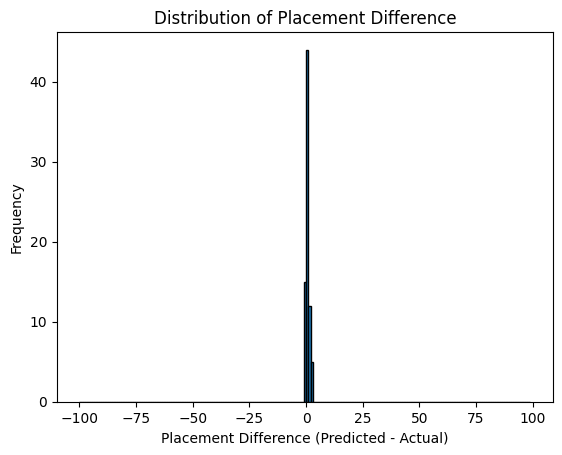

In [73]:

# Calculate the difference between predicted placement and actual placement
placement_difference = predicted_placements - actual_placements

# Create a histogram of the placement difference
plt.hist(placement_difference, bins=range(-100, 100), edgecolor='black')

# Set the labels and title
plt.xlabel('Placement Difference (Predicted - Actual)')
plt.ylabel('Frequency')
plt.title('Distribution of Placement Difference')

# Show the plot
plt.show()

In [74]:
# Predict whether a team will qualify for March Madness

In [77]:
# Predict final post season result
# Load the cbb24 dataset
directory = 'march_mad_data'

# Load cbb24.csv dataset into a dataframe
for filename in os.listdir(directory):
    if filename.endswith("cbb24.csv"):
        path = os.path.join(directory, filename)
        dataframes[filename] = pd.read_csv(path)

df_cbb24 = dataframes["cbb24.csv"]

# Preprocess the cbb24 dataset
cbb24_clean_df = df_cbb24.replace("N/A", "NA")
cbb24_clean_df = cbb24_clean_df.drop(columns=['TEAM'])
one_hot_encoded = pd.get_dummies(cbb24_clean_df['CONF'])
cbb24_clean_df = cbb24_clean_df.drop(columns=['CONF'])
cbb24_clean_df = pd.concat([cbb24_clean_df, one_hot_encoded], axis=1)
cbb24_clean_df['WINRATE'] = cbb24_clean_df['W'] / cbb24_clean_df['G']
cbb24_clean_df.dropna(inplace=True)

# Select the relevant columns for prediction
prediction_features = ['SEED', 'WINRATE', 'ADJOE', 'ADJDE', 'EFG_O', 'EFG_D', 'TOR', '2P_O', '2P_D']

# Make predictions using the best model
cbb24_predictions = final_rf.predict(cbb24_clean_df[prediction_features])

# Map the predicted values to the corresponding postseason placements
placement_predictions = []
for i in range(len(cbb24_predictions)):
    if cbb24_predictions[i] == 1:
        placement_predictions.append("Champions") 
    elif cbb24_predictions[i] == 2:
        placement_predictions.append("2ND")
    elif cbb24_predictions[i] == 3:
        placement_predictions.append("F4")
    elif cbb24_predictions[i] == 4:
        placement_predictions.append("E8")
    elif cbb24_predictions[i] == 5:
        placement_predictions.append("S16")
    elif cbb24_predictions[i] == 6:
        placement_predictions.append("R32")
    elif cbb24_predictions[i] == 7:
        placement_predictions.append("R64")
    elif cbb24_predictions[i] == 8:
        placement_predictions.append("R68")

for i in range(len(cbb24_predictions)):
    print(f"School: {df_cbb24['TEAM'][i]}, Predicted Postseason Placement: {placement_predictions[i]}")




School: Houston, Predicted Postseason Placement: S16
School: Connecticut, Predicted Postseason Placement: 2ND
School: Purdue, Predicted Postseason Placement: Champions
School: Iowa St., Predicted Postseason Placement: S16
School: Auburn, Predicted Postseason Placement: S16
School: Arizona, Predicted Postseason Placement: R32
School: Tennessee, Predicted Postseason Placement: S16
School: Marquette, Predicted Postseason Placement: R32
School: North Carolina, Predicted Postseason Placement: F4
School: Creighton, Predicted Postseason Placement: S16
School: Duke, Predicted Postseason Placement: S16
School: Illinois, Predicted Postseason Placement: R32
School: Saint Mary's, Predicted Postseason Placement: R32
School: Gonzaga, Predicted Postseason Placement: S16
School: Alabama, Predicted Postseason Placement: S16
School: Kansas, Predicted Postseason Placement: R32
School: Baylor, Predicted Postseason Placement: S16
School: BYU, Predicted Postseason Placement: R64
School: Wisconsin, Predicted